# Goal of this Lab
* Handle mixed (i.e., categorical + numeric data) and imbalanced (i.e., label distribution is skewed) data set.
* Evaluate a classification model with *k*-fold cross validation.
* Understand a classification model in terms of feature importances, a structure, and each sample's effect on predicted outcomes.

# Required Packages
* Datasets: *kse801-dataset*
* Imbalanced data handling: *imblearn*
* Classification model: *xgboost* and *lightgbm*.
* Model explanation: *shap*

In [1]:
%pip install --upgrade kse801-dataset imblearn xgboost lightgbm shap

     |████████████████████████████████| 62.9 MB 15 kB/s 
     |████████████████████████████████| 193.7 MB 30 kB/s 
     |████████████████████████████████| 2.0 MB 25.8 MB/s 
     |████████████████████████████████| 564 kB 12.3 MB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


# Dataset: Receptivity to Just-in-Time Health Intervention
* Receptivity data set aims to model a user's response behaviors upon mobile-based Just-in-Time intervention.

* In this intervention, the user received a healthy behavior suggestion (e.g., "*Stand up and move for a while*") via a smartphone notification, when they sit down for an hour.

* The users reported responses on a given intervention message:
  1. Perception vs. Missing: whether users perceived or missed an incoming suggestion
  2. Availability vs. Unavailability: whether users thought available to stand up and move for a while.
  3. Adherence vs. Rejection: whether users actually performed standing up and moving or not.

* For each intervention message, we extracted about 1,000 features based on users' smartphone data and assigned class labels based on users' responses. 

## Retrieve Dataset

In [ ]:
import numpy as np
from kse801.abc import load_receptivity

DATA_SET = load_receptivity()

print('# Feature')
print('- Shape: {}'.format(DATA_SET['feature'].shape))
print(DATA_SET['feature'].iloc[:5], '\r\n')

print('# Label')
print('- Shape: {}'.format(DATA_SET['label'].shape))
print(DATA_SET['label'].iloc[:5], '\r\n')

print('# Group (or Subject ID)')
print('- Shape: {}'.format(DATA_SET['group'].shape))
print('- Unique group: {}'.format(np.unique(DATA_SET['group'])))
print(DATA_SET['group'], '\r\n')

print('# Categorical column names')
print(DATA_SET['categories'])

# Feature
- Shape: (1601, 1049)
   ACT#12HR#ACTV_DUR  ACT#12HR#ACTV_FRQ  ACT#12HR#ETRP_DUR  ACT#12HR#ETRP_FRQ  \
0           0.110810                2.0           0.348206           0.673012   
1           0.051629                2.0           0.203286           0.693147   
2           0.438717               36.0           1.051710           1.094624   
3           0.061550                2.0           0.267954           1.011404   
4           0.132087               11.0           0.390335           0.692202   

   ACT#12HR#IDLE_DUR  ACT#12HR#IDLE_FRQ  ACT#12HR#IN_VEHICLE_DUR  \
0           0.889190                3.0                 0.000000   
1           0.948371                2.0                 0.000000   
2           0.561283               37.0                 0.177537   
3           0.938450                4.0                 0.006089   
4           0.867913               12.0                 0.000000   

   ACT#12HR#IN_VEHICLE_FRQ  ACT#12HR#ON_BICYCLE_DUR  ACT#12HR#ON_BICYCLE

* As shown above, features are mixed with numeric and categorical data. For example, a duration of screen-off is numeric, but a current state of screen (i.e., on vs. off) is categorical.

* Each sample has three different class labels, *perception*, *availability*, and *adherence*. Each class label can have a value 1 vs 0 (or, True or False).

* In this lab, we will use data labeled as, *perception*, from the participant, *P11*.

In [ ]:
import numpy as np

# Feature data for the participant P11
FEATURE = DATA_SET['feature'].loc[DATA_SET['group'] == 'P11', :]

# Class label, perception, for the participant P11 
LABEL = DATA_SET['label'].loc[DATA_SET['group'] == 'P11', 'perception']

# Categorical column names
CATEGORY = list(DATA_SET['categories']) 

print('# Feature data')
print('- # rows = {} / # columns = {}'.format(FEATURE.shape[0], FEATURE.shape[1]))
print(FEATURE.head(), '\r\n')

print('# Class label')
print(LABEL.head(), '\r\n')

print('# Label distribution')
print('- # label = 0: {}'.format(np.count_nonzero(LABEL == 0)))
print('- # label = 1: {}'.format(np.count_nonzero(LABEL == 1)), '\r\n')

print('# Categorical feature names')
print(CATEGORY, '\r\n')

# Feature data
- # rows = 144 / # columns = 1049
     ACT#12HR#ACTV_DUR  ACT#12HR#ACTV_FRQ  ACT#12HR#ETRP_DUR  \
599           0.064410                6.0           0.238932   
600           0.064410                6.0           0.238932   
601           0.064410                6.0           0.238932   
602           0.104966                9.0           0.335859   
603           0.106366               10.0           0.338850   

     ACT#12HR#ETRP_FRQ  ACT#12HR#IDLE_DUR  ACT#12HR#IDLE_FRQ  \
599           0.690186           0.935590                7.0   
600           0.690186           0.935590                7.0   
601           0.690186           0.935590                7.0   
602           0.691761           0.895034               10.0   
603           0.692013           0.893634               11.0   

     ACT#12HR#IN_VEHICLE_DUR  ACT#12HR#IN_VEHICLE_FRQ  \
599                      0.0                      0.0   
600                      0.0                      0.0   
601       

# Steps for Model Evaluation
1. Splits entire dataset (suppose the number of samples is $N$) into $k$ folds, where each fold contains $N\frac{k-1}{k}$ train set and $\frac{N}{k}$ test set.

2. For each fold, 
  1. Over-sample train set in the minority class.

  2. Transform numeric features into uniformly-scaled values (e.g., from 0.0 to 1.0)
  3. Transform categorical features into dummy-/ordinal-encoded numbers, depending on a classification algorithm.
  4. Build a classification model using features and labels from train set
  5. Retrieve prediction results using features from test set
  6. Calculate performance metrics using prediction results above and labels from test set.

3. Aggregate (e.g., average, standard devation) performance metrics retrieved from all folds.

![test](http://drive.google.com/uc?export=view&id=1kqFDq_XOavc8HdUoppOB6rcgato2HeUa)

## *k*-fold Splitting
* Types of datasets in machine learning are:
  1. Train set: dataset to train a model
  2. Validation set: dataset to tune hyperparmeters of the model
  3. Test set: dataset to evaluate (final) performance of the model; generally they are unseen during training the model.

* Originally, to evaluate a machine learning model, we should seperate entire data set into above three types of datasets, and train, tune hyperparameters, and evaluate the performance.

* However, in most cases, we cannot do such because of the limited amount of data.

* Instead, we can split our entire dataset into multiple folds that are comprised of train and test (or, validation) set, and conduct model evaluation for each fold.

* To allow each fold to preserve percentage of samples for each class, we use [scikit-learn's StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold).
  * Suppose that *5* and *10* samples are labeled as *Yes* and *No*, respectively. Then, we want each fold includes *4 Yes'es/8 No's* in train set, and *1 Yes/2 No's* in test set.

In [ ]:
from sklearn.model_selection import StratifiedKFold

K_FOLDS = []

# n_splits: the number of folds.
# shuffle: whether data are shuffled before splitting.
splitter = StratifiedKFold(n_splits=5, shuffle=True) 

# Here, 'train_indices' and 'test_indices' is numpy's array indicating indices of data.
for idx, (train_indices, test_indices) in enumerate(splitter.split(FEATURE, LABEL)): 
  X_train = FEATURE.iloc[train_indices] 
  y_train = LABEL.iloc[train_indices]

  X_test = FEATURE.iloc[test_indices]
  y_test = LABEL.iloc[test_indices]

  # Just for pretty print
  print('# {}-th fold'.format(idx + 1))
  print('\t- # train: {} / # test: {}'.format(X_train.shape[0], X_test.shape[0]))
  print('\t- Label dist. in train: label 0 = {} / label 1 = {}'.format(np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1)))
  print('\t- Label dist. in test: label 0 = {} / label 1 = {}'.format(np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1)))

  # Here, we store train and test set of each fold into dictionary.
  K_FOLDS.append((X_train, y_train, X_test, y_test))

# See the 1st fold's train and test features
X_train, _, X_test, _ = K_FOLDS[0]
print('# The training features in the 1st fold')
print(X_train.head(), '\r\n')

print('# The test features in the 1st fold')
print(X_test.head(), '\r\n')

# 1-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 12 / label 1 = 103
	- Label dist. in test: label 0 = 4 / label 1 = 25
# 2-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 13 / label 1 = 102
	- Label dist. in test: label 0 = 3 / label 1 = 26
# 3-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 13 / label 1 = 102
	- Label dist. in test: label 0 = 3 / label 1 = 26
# 4-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 13 / label 1 = 102
	- Label dist. in test: label 0 = 3 / label 1 = 26
# 5-th fold
	- # train: 116 / # test: 28
	- Label dist. in train: label 0 = 13 / label 1 = 103
	- Label dist. in test: label 0 = 3 / label 1 = 25
# The training features in the 1st fold
     ACT#12HR#ACTV_DUR  ACT#12HR#ACTV_FRQ  ACT#12HR#ETRP_DUR  \
599           0.064410                6.0           0.238932   
600           0.064410                6.0           0.238932   
601           0.064410                

## Over-sample Data in Minority Class
* As shown in the label distribution within each fold, our data is severely *imbalanced*: the amount of samples labeled as **1** (meaning a user perceived a message) is overwhelmingly larger than samples labeled as **0** (meaning a user missed the message).

* Such label imbalance potentially results in a poor classificsation model, which cannot distinguish different labels.

* Absolutely, the best solution for this problem is **to collect more samples in the minority class**; however, in most cases, it is impossible.

* Instead, we can computationally increase the amount of samples in the minority class, called *over-sampling*.

* One alternative is to repeteadly select random samples in the minority class: **Random over-sampling**
  * This is simple, but we cannot acheive diversity of samples.

* Another (promising) alternative is to generate synthetic samples based on a distribution of minority-class samples.
  * One of popular algorithms for this is **SMOTE** (**S**ynthetic **M**inority **O**ver-sampling **Te**chnique).
![대체 텍스트](https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png)

  * SMOTE has many variations, such as *BorderlineSMOTE*, *SVM-SMOTE*, *KMeans SMOTE*. However, those can handle only **numeric data**.

  * Because our dataset include both **numeric** and **categorical** values, we should use a special variation of SMOTE, called **SMOTE-NC**.

  * Implementations of those algorithms are provided by [imbalanced-learn](https://imbalanced-learn.readthedocs.io/).

* **Important note**
  * Over-sampling should be conducted only in **training data**, not **test data**. 
  * In machine learning, test data is supposed to be immutable. Therefore, we should not change its amount or distribution.

In [ ]:
from imblearn.over_sampling import SMOTENC
import pandas as pd
import numpy as np

K_FOLDS_RESAMPLE = []

for idx, (X_train, y_train, X_test, y_test) in enumerate(K_FOLDS):
  # categorical_features: masked arrays indicating where categorical feature is placed.
  sampler = SMOTENC(categorical_features=FEATURE.columns.isin(CATEGORY))

  # 'fit_resample' conducts over-sampling data in the minority class.
  # Again, resampling should be only conducted in train set.
  X_sample, y_sample = sampler.fit_resample(X_train, y_train)

  # Because SMOTENC.fit_resample() returns a tuple of numpy's array (not DataFrame or Series!),
  # We need to again build DataFrame and Series from resampled data.
  X_sample = pd.DataFrame(X_sample, columns=X_train.columns)
  y_sample = pd.Series(y_sample)

  K_FOLDS_RESAMPLE.append((X_sample, y_sample, X_test, y_test))
  
  # Just for pretty print
  print('# {}-th fold'.format(idx + 1))
  print('\t- # train: {} / # test: {}'.format(X_sample.shape[0], X_test.shape[0]))
  print('\t- Label dist. in train: 0 = {} / 1 = {}'.format(np.count_nonzero(y_sample == 0), np.count_nonzero(y_sample == 1)))
  print('\t- Label dist. in test: 0 = {} / 1 = {}'.format(np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1)))

# 1-th fold
	- # train: 206 / # test: 29
	- Label dist. in train: 0 = 103 / 1 = 103
	- Label dist. in test: 0 = 4 / 1 = 25
# 2-th fold
	- # train: 204 / # test: 29
	- Label dist. in train: 0 = 102 / 1 = 102
	- Label dist. in test: 0 = 3 / 1 = 26
# 3-th fold
	- # train: 204 / # test: 29
	- Label dist. in train: 0 = 102 / 1 = 102
	- Label dist. in test: 0 = 3 / 1 = 26
# 4-th fold
	- # train: 204 / # test: 29
	- Label dist. in train: 0 = 102 / 1 = 102
	- Label dist. in test: 0 = 3 / 1 = 26
# 5-th fold
	- # train: 206 / # test: 28
	- Label dist. in train: 0 = 103 / 1 = 103
	- Label dist. in test: 0 = 3 / 1 = 25


## Scale Numeric Data
* Our numeric features follow their own scales; for example, one feature may have values ranged from 0.0 to 1.0, but others may be in -1.0 to 3.0.
* Such different scales across features may result in incorrectly-built model (for linear models, like Linear SVM, logistic regression, etc) or longer training time (for deep learning).
* Although tree-based ensemble models (e.g., Random forest, XGBoost, Extra trees, etc) are robust to handle different scales, I recommend to scale numeric data like a ritual.
* In this lab, we use [scikit-learn's MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

* **Important note**
  * Feature scaling should be conducted only in **numeric data**.
  * When scaling data, first find data characteristics required in a certain scaling method (e.g., min, max, mean, std. dev.) on **train data**. And then, do scaling with **train and test data using such characteristics**. Because test data are supposed to be unseen, we **do not know** data charateristics on test data. That is the reason why we should not scale test data using their own characteristic.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

K_FOLDS_SCALED = []

for X_train, y_train, X_test, y_test in K_FOLDS_RESAMPLE:
  # Because scaling should be applied only to numeric data, 
  # we first choose numeric data from train and test set.
  # Here x in labmda means DataFrame itself.
  X_train_numeric = X_train.loc[:, lambda x: ~x.columns.isin(CATEGORY)]
  X_test_numeric = X_test.loc[:, lambda x: ~x.columns.isin(CATEGORY)]

  # To merge scaled numeric features and original categorical features into a single DataFrame,
  # we also choose categorical data from train and test set.
  X_train_category = X_train.loc[:, lambda x: x.columns.isin(CATEGORY)]
  X_test_category = X_test.loc[:, lambda x: x.columns.isin(CATEGORY)]

  scaler = MinMaxScaler()

  # StandardScaler.fit() finds characteristics of data distribution (i.e., min, max) in train set.
  scaler.fit(X_train_numeric)
  
  # Transform numeric data within train and test set.
  X_train_scale = scaler.transform(X_train_numeric)
  X_test_scale = scaler.transform(X_test_numeric)

  # Because MinMaxScaler.transform() returns a tuple of numpy's array (not DataFrame or Series!),
  # We need to again build DataFrame from scaled numeric data.
  X_train_scale = pd.DataFrame(
      X_train_scale, index=X_train_numeric.index, columns=X_train_numeric.columns
  )
  X_test_scale = pd.DataFrame(
      X_test_scale, index=X_test_numeric.index, columns=X_test_numeric.columns
  )

  # Merge scaled numeric data and categorical data into one DataFrame.
  X_train = pd.concat([X_train_scale, X_train_category], sort=False, axis=1)
  X_test = pd.concat([X_test_scale, X_test_category], sort=False, axis=1)

  K_FOLDS_SCALED.append((X_train, y_train, X_test, y_test))

# See the 1st fold's train and test features
X_train, _, X_test, _ = K_FOLDS_SCALED[0]
print('# The training features in the 1st fold')
print(X_train.head(), '\r\n')

print('# The test features in the 1st fold')
print(X_test.head(), '\r\n')

# The training features in the 1st fold
   ACT#12HR#ACTV_DUR  ...  TIM#CURRENT#SLOT
0           0.366332  ...             LUNCH
1           0.366332  ...             LUNCH
2           0.366332  ...             LUNCH
3           0.596996  ...            DINNER
4           0.604961  ...             NIGHT

[5 rows x 1049 columns] 

# The test features in the 1st fold
     ACT#12HR#ACTV_DUR  ...  TIM#CURRENT#SLOT
604           0.329541  ...             NIGHT
605           0.090912  ...           MORNING
616           0.022511  ...           MORNING
619           0.492281  ...             NIGHT
626           0.531248  ...             NIGHT

[5 rows x 1049 columns] 



## Encode Categorical Data
* Typically, implementations of major machine algorithms cannot directly handle *string-formatted categorical feature*.

* Therefore, we should transform (or encode) our categorical features into the number using either dummy encoding (a.k.a. One-hot-encoding) or ordinal encoding.

* Dummy encoding (a.k.a One-hot-encoding)

  * This scheme transforms a categorical feature having $k$ cardinality (i.e., $k$ unique values) into $k$ (or, $k-1$ for linear models) categorical features where each feature has 2 cardinality (i.e., 0 or 1).

  * Most of classification algorithms require one-hot-encoding to handle categorical features.

  * [scikit-learn's OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) or [pandas' get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html#pandas.get_dummies) can be used to do this.

|Cat. feature|->|Cat. feature. Yes|Cat. feature. No|Cat. feature. WTF|
|---||---|---|---|
| Yes |->|1|0|0|
| No  |->|0|1|0|
| WTF|->|0|0|1|
  
* Ordinal encoding
  * This scheme transforms a categorical feature having $k$ cardinality into the categorical feature having $k$ ordinal numbers.

  * This can be used in some classification algorithms which specialize categorical feature handling (e.g., [CatBoost](https://catboost.ai/), [LightGBM](https://lightgbm.readthedocs.io/)) 
  * [scikit-learn's OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) can be used to do this.

|Cat. feature|->|Cat. feature|
|---||---|
| Yes |->|0|
| No  |->|1|
| WTF|->|2|

* In this lab, we will practice both one-hot-encoding (for XGBoost) and ordinal encoding (for LightGBM).

* **Important note**
  * As a convention, numeric data would be formmated as *floating point*, and categorical data would be formatted as *unsigned integer*.

### One-hot-encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# To find all available categories for each categorical feature,
# we first retrieve categorical feature data from our dataset.
categorical_data = FEATURE.loc[:, lambda x: x.columns.isin(CATEGORY)] 

# Encoded values are formatted as 8-bit unsigned integer.
encoder = OneHotEncoder(dtype='uint8', sparse=False) 

# fit(): find unique categories for each column.
encoder.fit(categorical_data) 

print('# Categories')
print(encoder.categories_, '\r\n')

K_FOLDS_OHE = []

for X_train, y_train, X_test, y_test in K_FOLDS_SCALED:
  # Because encoding should be applied only to categorical data, 
  # we first choose categorical data from train and test set.
  # Here x in labmda means DataFrame itself.
  X_train_category = X_train.loc[:, lambda x: x.columns.isin(CATEGORY)]
  X_test_category = X_test.loc[:, lambda x: x.columns.isin(CATEGORY)]

  # To merge numeric features and encoded categorical features into a single DataFrame,
  # we also choose numeric data from train and test set.
  X_train_numeric = X_train.loc[:, lambda x: ~x.columns.isin(CATEGORY)]
  X_test_numeric = X_test.loc[:, lambda x: ~x.columns.isin(CATEGORY)]

  # Conduct one-hot-encoding in categorical data.
  X_train_encoded = encoder.transform(X_train_category)
  X_test_encoded = encoder.transform(X_test_category)

  # Because one-hot-encoding increase the number of feature columns,
  # we should retrieve new feature names for them.
  X_train_enc_names = encoder.get_feature_names(X_train_category.columns)
  X_test_enc_names = encoder.get_feature_names(X_test_category.columns)

  # Because OneHotEncoder.transform() returns a tuple of numpy's array (not DataFrame or Series!),
  # We need to again build DataFrame from encoded categorical data.
  X_train_encoded = pd.DataFrame(
      X_train_encoded, index=X_train_category.index, columns=X_train_enc_names
  )
  X_test_encoded = pd.DataFrame(
      X_test_encoded, index=X_test_category.index, columns=X_test_enc_names
  )
  # Merge numeric data and encoded categorical data into one DataFrame.
  X_train = pd.concat([X_train_numeric, X_train_encoded], sort=False, axis=1)
  X_test = pd.concat([X_test_numeric, X_test_encoded], sort=False, axis=1)

  K_FOLDS_OHE.append((X_train, y_train, X_test, y_test))


# See the 1st fold's train and test features
X_train, _, X_test, _ = K_FOLDS_OHE[0]
print('# The training features in the 1st fold')
print(X_train.head(), '\r\n')

print('# The test features in the 1st fold')
print(X_test.head(), '\r\n')

# Categories
[array(['MOBILE', 'WIFI'], dtype=object), array(['TOP-01-PLACE', 'TOP-02-PLACE', 'TOP-03-PLACE', 'TOP-04-PLACE',
       'TOP-05-PLACE', 'TOP-06-PLACE', 'TOP-07-PLACE', 'TOP-10-PLACE',
       'UNDEFINED'], dtype=object), array(['FALSE', 'TRUE'], dtype=object), array(['NORMAL'], dtype=object), array(['OFF', 'ON'], dtype=object), array(['After sleeping', 'Calling/Texting', 'Chilling', 'Conversing',
       'Driving', 'Eating', 'Engaging in a meeting/class', 'Other',
       'Sleeping', 'Watching', 'Working/Studying'], dtype=object), array(['-1', '-2', '0', '1'], dtype=object), array(['-1', '-3', '0', '1', '2'], dtype=object), array(['Eatery', 'Home', 'Other', 'Vehicle', 'Work'], dtype=object), array(['Alone', 'Social'], dtype=object), array(['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'], dtype=object), array(['FALSE', 'TRUE'], dtype=object), array(['AFTERNOON', 'DINNER', 'LUNCH', 'MORNING', 'NIGHT'], dtype=object)] 

# The training features in the 1st fold
   ACT#12HR#ACTV_D

### Ordinal Encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# We first find all available categories for each categorical feature.
categorical_data = FEATURE.loc[:, lambda x: x.columns.isin(CATEGORY)] 

# Encoded values are formatted as 8-bit unsigned integer.
encoder = OrdinalEncoder(dtype='uint8') 

# fit(): find unique categories for each column.
encoder.fit(categorical_data) 

print('# Categories')
print(encoder.categories_, '\r\n')

K_FOLDS_ODE = []

for X_train, y_train, X_test, y_test in K_FOLDS_SCALED:
  # Because encoding should be applied only to categorical data, 
  # we first choose categorical data from train and test set.
  # Here x in labmda means DataFrame itself.
  X_train_category = X_train.loc[:, lambda x: x.columns.isin(CATEGORY)]
  X_test_category = X_test.loc[:, lambda x: x.columns.isin(CATEGORY)]

  # To merge numeric features and encoded categorical features into a single DataFrame,
  # we also choose numeric data from train and test set.
  X_train_numeric = X_train.loc[:, lambda x: ~x.columns.isin(CATEGORY)]
  X_test_numeric = X_test.loc[:, lambda x: ~x.columns.isin(CATEGORY)]

  # Conduct ordinal encoding in categorical data.
  X_train_encoded = encoder.transform(X_train_category)
  X_test_encoded = encoder.transform(X_test_category)

  # Because OneHotEncoder.transform() returns a tuple of numpy's array (not DataFrame or Series!),
  # We need to again build DataFrame from encoded categorical data.
  X_train_encoded = pd.DataFrame(
      X_train_encoded, index=X_train_category.index, columns=X_train_category.columns
  )
  X_test_encoded = pd.DataFrame(
      X_test_encoded, index=X_test_category.index, columns=X_test_category.columns
  )

  # Merge numeric data and encoded categorical data into one DataFrame.
  X_train = pd.concat([X_train_numeric, X_train_encoded], sort=False, axis=1)
  X_test = pd.concat([X_test_numeric, X_test_encoded], sort=False, axis=1)

  K_FOLDS_ODE.append((X_train, y_train, X_test, y_test))

# See the 1st fold's train and test features
X_train, _, X_test, _ = K_FOLDS_ODE[0]
print('# The training features in the 1st fold')
print(X_train.head(), '\r\n')

print('# The test features in the 1st fold')
print(X_test.head(), '\r\n')

# Categories
[array(['MOBILE', 'WIFI'], dtype=object), array(['TOP-01-PLACE', 'TOP-02-PLACE', 'TOP-03-PLACE', 'TOP-04-PLACE',
       'TOP-05-PLACE', 'TOP-06-PLACE', 'TOP-07-PLACE', 'TOP-10-PLACE',
       'UNDEFINED'], dtype=object), array(['FALSE', 'TRUE'], dtype=object), array(['NORMAL'], dtype=object), array(['OFF', 'ON'], dtype=object), array(['After sleeping', 'Calling/Texting', 'Chilling', 'Conversing',
       'Driving', 'Eating', 'Engaging in a meeting/class', 'Other',
       'Sleeping', 'Watching', 'Working/Studying'], dtype=object), array(['-1', '-2', '0', '1'], dtype=object), array(['-1', '-3', '0', '1', '2'], dtype=object), array(['Eatery', 'Home', 'Other', 'Vehicle', 'Work'], dtype=object), array(['Alone', 'Social'], dtype=object), array(['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'], dtype=object), array(['FALSE', 'TRUE'], dtype=object), array(['AFTERNOON', 'DINNER', 'LUNCH', 'MORNING', 'NIGHT'], dtype=object)] 

# The training features in the 1st fold
   ACT#12HR#ACTV_D

## Model Building and Evaluation
* Finally, we have completed data preprocessing.

* From now, we will actually build a classification model and evaluate its performance.

* As stated above, model building and evaluation is conducted every fold.

* The final performance metrics are calculated by averaging performance metrics of all folds.

* In this lab, we will practice [XGBoost](https://xgboost.readthedocs.io/) and [LightGBM](https://lightgbm.readthedocs.io/).
  * Both algorithms find gradient-boosted trees,but their implementation is different (i.e., training efficiency, and classification performance improvement). And their performances differ across datasets. If you want to learn more about these algorithms, please refer to this article: https://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/ 
  * One caveat for practical usage is that LightGBM has a special mechanism to handle categorical data. Thus, for XGBoost, we will use *one-hot-encoded data*, and for LightGBM, we will use *ordinally-encoded data*.

### XGBoost

In [ ]:
! pip install xgboost

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix
import plotly.graph_objs as go

# This is used to store models for each fold.
XGB_MODELS = []

# Balanced accuracy, F1 score, and ROC-AUC score.
scores = {
    'acc': [],
    'f1': [],
    'roc_auc': []
}

# 2 X 2 confusion matrix
conf_mtx = np.zeros((2, 2))

for X_train, y_train, X_test, y_test in K_FOLDS_OHE:
  # XGBoost requires a special data structure, xgboost.DMatrix()
  # Here we build DMatrix for train and test set.
  dtrain = xgb.DMatrix(data=X_train, label=y_train.to_numpy())
  dtest = xgb.DMatrix(data=X_test, label=y_test.to_numpy())

  # xgboost.train() conducts actual model training and returns a trained model.
  # For detailed parameter setting, please check: https://xgboost.readthedocs.io/en/latest/parameter.html
  booster = xgb.train(
      params=dict(
        eval_metric='auc',
        booster='gbtree',
        verbosity=0,
        objective='binary:logistic'
      ),
      # dtrain: DMatrix of training data
      dtrain=dtrain,
      # num_boost_round: the number of boosted trees
      num_boost_round=100, 
      # early_stopping_rounds: early stop generating trees when eval_metric is not improved
      early_stopping_rounds=25,
      # evals: evaluation set to check early stooping
      evals=[(dtest, 'test')],
      verbose_eval=False
  )
  # predict() returns probability of a positive label (label == 1)
  y_pred = booster.predict(
      # dtest: DMatrix of test data set
      data=dtest, 
      # ntree_limit: the number of boosted trees used for prediction.
      # booster.best_ntree_limit returns the number of trees that show best performance.
      ntree_limit=booster.best_ntree_limit)
  
  # Because predict() returns probability, we should change them into class labels.
  # Here, we set cur-off as 0.5: positive label when a probability is higher than 0.5.
  y_pred_class = np.where(y_pred > 0.5, 1, 0)

  acc = balanced_accuracy_score(y_test, y_pred_class)
  f1 = f1_score(y_test, y_pred_class, average='macro')
  roc_auc = roc_auc_score(y_test, y_pred)

  scores['acc'].append(acc)
  scores['f1'].append(f1)
  scores['roc_auc'].append(roc_auc)
  conf_mtx += confusion_matrix(y_test, y_pred_class)
  
  XGB_MODELS.append(booster)


print('# Classification results')
for k, v in scores.items():
  print('- {}: {}'.format(k.upper(), np.mean(v)))

fig = go.Figure(
    go.Heatmap(
        x=['Pred. Label = 0', 'Pred Label = 1'],
        y=['True. Label = 1', 'True. Label = 0'],
        z=np.flip(conf_mtx, axis=0)
    )
)
fig.update_layout(
    title_text='Confusion matrix for XGBoost evaluation',
    xaxis_title_text='Prediction',
    yaxis_title_text='True'
)
fig.show()

# Classification results
- ACC: 0.7479487179487179
- F1: 0.7191943568414156
- ROC_AUC: 0.8597307692307693


### LightGBM

In [ ]:
import lightgbm as gbm
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix
import plotly.graph_objs as go

# This is used to store models for each fold.
GBM_MODELS = []

# Balanced accuracy, F1 score, and ROC-AUC score.
scores = {
    'acc': [],
    'f1': [],
    'roc_auc': []
}

# 2 X 2 confusion matrix
conf_mtx = np.zeros((2, 2))

for X_train, y_train, X_test, y_test in K_FOLDS_ODE:
  # LightGBM requires a special data structure, lightgbm.Dataset()
  # Here we build Dataset for train and test set.
  # Difference from XGBoost is 'categorical_feature', meaning column names of categorical features.
  dtrain = gbm.Dataset(data=X_train, 
                       label=y_train.to_numpy(), 
                       categorical_feature=CATEGORY)
  dtest = gbm.Dataset(data=X_test, 
                      label=y_test.to_numpy(), 
                      categorical_feature=CATEGORY)
  
  # lightgbm.train() conducts actual model training and returns a trained model.
  # For detailed parameter setting, please check:https://lightgbm.readthedocs.io/en/latest/Parameters.html
  booster = gbm.train(
      params=dict(
        metric='auc',
        boosting='gbdt',
        boost_from_average=True,
        objective='binary'
      ),
      # categorical_feature: same as Dataset's categorical feature
      categorical_feature=CATEGORY,
      # train_set: Dataset of test set
      train_set=dtrain,
      # num_boost_round: the maximum number of boosted trees
      num_boost_round=100, 
      # early_stopping_rounds: early stop generating trees when eval_metric is not improved
      early_stopping_rounds=25, 
      # valid_sets: evaluation set to check early stopping
      valid_sets=[dtest],
      # valid_names: names of evaluation set
      valid_names=['test'],
      verbose_eval=False
  )

  # predict() returns probability of a positive label (label == 1)
  y_pred = booster.predict(
      X_test, 
      # num_iteration: the number of boosted trees used for prediction.
      # booster.best_iteration returns the number of trees that show best performance.
      num_iteration=booster.best_iteration)

  # Because predict() returns probability, we should change them into class labels.
  # Here, we set cur-off as 0.5: positive label when a probability is higher than 0.5.
  y_pred_class = np.where(y_pred > 0.5, 1, 0)

  acc = balanced_accuracy_score(y_test, y_pred_class)
  f1 = f1_score(y_test, y_pred_class, average='macro')
  roc_auc = roc_auc_score(y_test, y_pred)

  scores['acc'].append(acc)
  scores['f1'].append(f1)
  scores['roc_auc'].append(roc_auc)
  conf_mtx += confusion_matrix(y_test, y_pred_class)
  
  GBM_MODELS.append(booster)


print('# Classification results')
for k, v in scores.items():
  print('- {}: {}'.format(k.upper(), np.mean(v)))

fig = go.Figure(
  go.Heatmap(
      x=['Pred. Label = 0', 'Pred Label = 1'],
      y=['True. Label = 1', 'True. Label = 0'],
      z=np.flip(conf_mtx, axis=0)
  )
)
fig.update_layout(
    title_text='Confusion matrix for LightGBM evaluation',
    xaxis_title_text='Prediction',
    yaxis_title_text='True'
)
fig.show()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



# Classification results
- ACC: 0.6683076923076923
- F1: 0.6401874230221996
- ROC_AUC: 0.8571794871794871


# Model Explanation
* To deepen our understanding of prediction models, we can inspect (1) important features to build a classifaction model, (2) a tree structure of a model, and (3) contribution of features to predicted labels.


## Feature Importance
* Feature importances in XGBoost and LightGBM mean what features contribute to split a tree structure.

### XGBoost
* To check feature importance of the XGBoost model, call 'get_fscore()' which returns a dictionary where a key is a feature name and a value is a feature importance. There are several different types when considering feature importance: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score Default: get_score(fmap='', importance_type='weight')
  * ‘weight’: ***the number of times*** a feature is used to split the data across all trees (default) 
  * ‘gain’: the average gain across all splits the feature is used in.
  *‘cover’: the average coverage across all splits the feature is used in.
  *‘total_gain’: the total gain across all splits the feature is used in.
  *‘total_cover’: the total coverage across all splits the feature is used in.
* Because we conduct 5-fold cross validations, we can get 5 feature importances in total. Final feature importances are calculated by averaging all of them.

In [ ]:
import plotly.graph_objs as go
import pandas as pd

feature_importances = {}

for model in XGB_MODELS:
  # get_fscore() returns a dictionary, where a key is a feature name and a value is feature importance.
  imp = model.get_fscore()

  for k, v in imp.items():
    # If a given feature name already exists, add feature importance into existing importance.
    if k in feature_importances:
      feature_importances[k] += v
    else:
      feature_importances[k] = v

feature_importances = [
  # Averaging feature importance
  (k, float(v) / 5)
  for k, v in feature_importances.items()
]

# Build dataframe from feature importances, and sort them by importances in descending order.
# And then, select top 50 features.
df = pd.DataFrame(feature_importances, 
                  columns=['name', 'importance']
                  ).sort_values('importance', ascending=False).head(50)

fig = go.Figure(
    go.Bar(
        x=df.loc[:, 'name'],
        y=df.loc[:, 'importance']
    )
)
fig.update_layout(
    title_text='Top 50 features for XGBoost',
    yaxis_title_text='Feature importances'
)
fig.show()


### LightGBM
* To check feature importance of the LightGBM model, call 'feature_importance() and feature_name()' which returns a feature importance and a corresponding feature name, respectively.

In [ ]:
import plotly.graph_objs as go
import pandas as pd

feature_importances = {}

for model in GBM_MODELS:
  # List of feature names
  names = model.feature_name()
  # List of feature importance.
  imp = model.feature_importance()
  
  for k, v in zip(names, imp):
    if k in feature_importances:
      feature_importances[k] += v
    else:
      feature_importances[k] = v

feature_importances = {
    (k, float(v) / 5)
    for k, v in feature_importances.items()
}

# Build dataframe from feature importances, and sort them by importances in descending order.
# And then, select top 50 features.
df = pd.DataFrame(feature_importances, 
                  columns=['name', 'importance']
                  ).sort_values('importance', ascending=False).head(50)

fig = go.Figure(
    go.Bar(
        x=df.loc[:, 'name'],
        y=df.loc[:, 'importance']
    )
)
fig.update_layout(
    title_text='Top 50 features for LightGBM',
    yaxis_title_text='Feature importances'
)
fig.show()

## Tree Structure
* We can visualize how our models are structured using *xgboost.plot_tree()* or *lightgbm.plot_tree()*.
* Unfortunately, both functions support *Matplotlib*, not *plotly*.
* Because we have different models (and their own tree structures) across folds, we should plot 5 different trees

### XGBoost

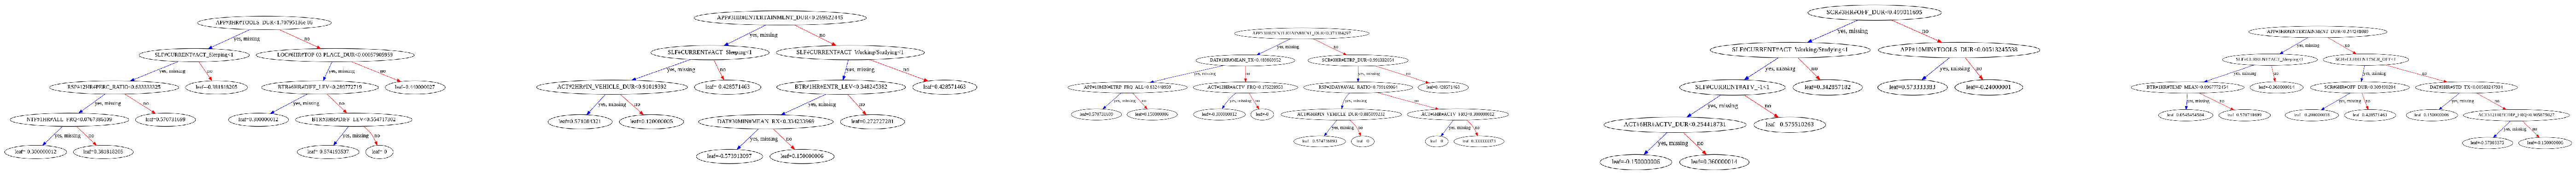

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(100, 25))

for model, ax in zip(XGB_MODELS, axes):
  xgb.plot_tree(model, ax=ax)

fig.show()

### LightGBM

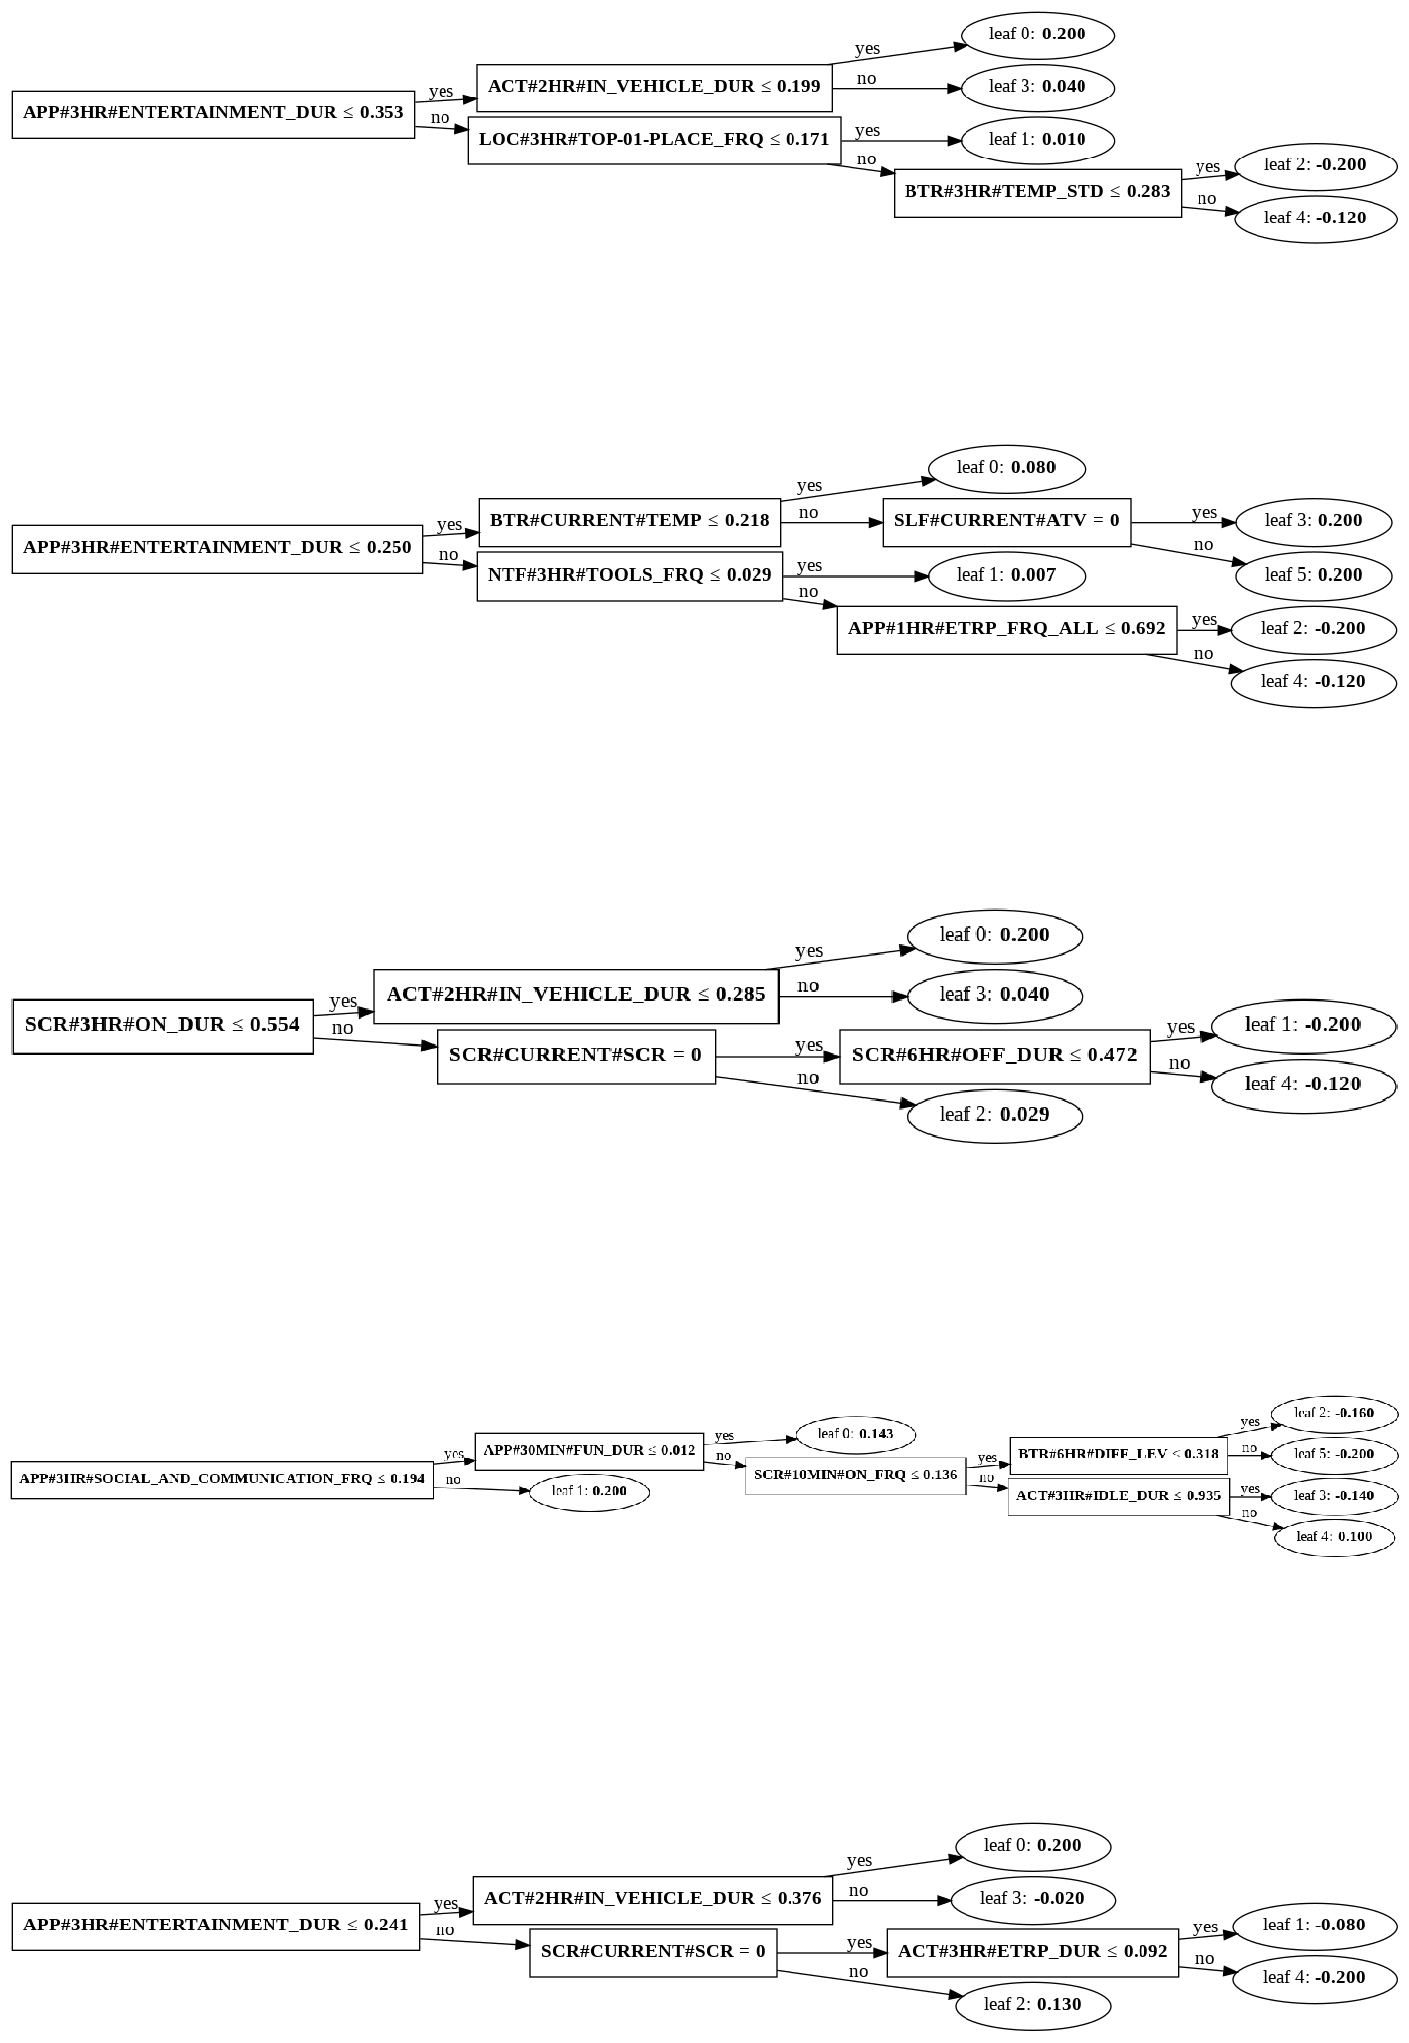

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as gbm

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(25, 40))

for model, ax in zip(GBM_MODELS, axes):
  gbm.plot_tree(model, ax=ax)

fig.show()

## Feature Contribution to Prediction
* Inspecting feature importances and tree structures would provide valuable insights about features and models. 
* However, we still do not know how each feature affects predicted labels.
* To explain them, we can utilize [SHAP](https://github.com/slundberg/shap) (**SH**apley **A**dditive ex**P**lanations): Please take a look at [this article ](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83) for explanation

### XGBoost


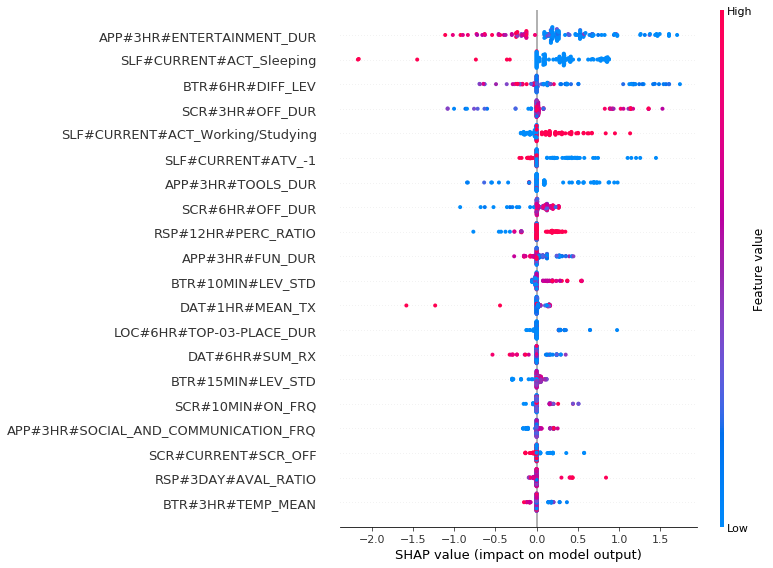

In [ ]:
import shap
import pandas as pd
import numpy as np

SHAP_VALUES = []
TEST_FEATURES = []

for (X_train, y_train, X_test, y_test), model in zip(K_FOLDS_OHE, XGB_MODELS):
  # shap.TreeExplainer() is used to explain tree-based ensemble models.
  explainer = shap.TreeExplainer(model)

  # TreeExplainer.shap_values indicate how features of each sample contribute to predicted output.
  shap_value = explainer.shap_values(X_test, tree_limit=model.best_ntree_limit)

  SHAP_VALUES.append(shap_value)
  TEST_FEATURES.append(X_test)

# Merging all shap values and train data.
SHAP_VALUES = np.vstack(SHAP_VALUES)
TEST_FEATURES = pd.concat(TEST_FEATURES, axis=0)

shap.summary_plot(SHAP_VALUES, TEST_FEATURES)


* When a feature, *APP#3HR#ENTERTAINMENT_DUR* (meaning a duration of entertainment app usage for 3 hours) increases, its SHAP value decreases (meaning label = 0 or perceiving a message).
* When a feature, *SLF#CURRENT#ACT_Sleeping* (meaning a subject are currently sleeping) increases, its SHAP value decreases (meaning label = 0 or missing a message)



### LightGBM


/usr/local/lib/python3.6/dist-packages/shap/explainers/tree.py:194: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



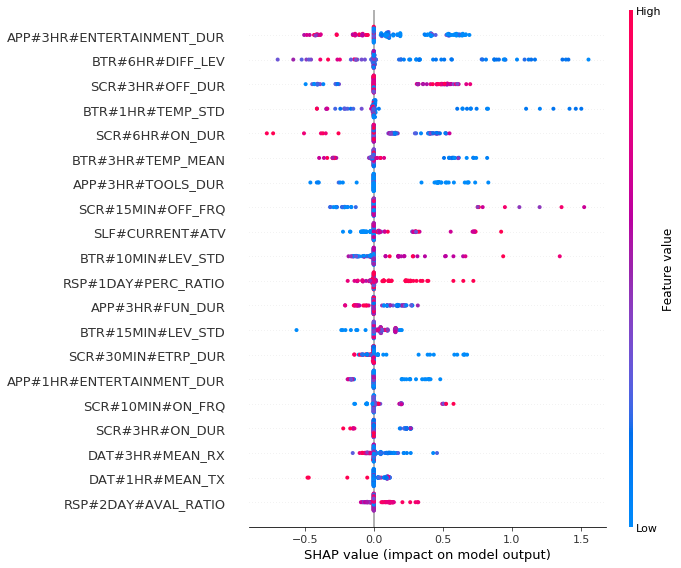

In [ ]:
import shap
import pandas as pd
import numpy as np

SHAP_VALUES = []
TEST_FEATURES = []

for (X_train, y_train, X_test, y_test), model in zip(K_FOLDS_ODE, GBM_MODELS):
  explainer = shap.TreeExplainer(model)
  
  # For LightGBM, TreeExplainer.shap_values() returns a list of shape values, 
  # where each element in a list is shap_values of each class.
  # In our case, the first element is shap_values for class label = 0, 
  # and the second one is shap_values for class label = 1.
  # We need to use only the second one.
  _, shap_value = explainer.shap_values(X_test, tree_limit=model.best_iteration)
  SHAP_VALUES.append(shap_value)
  TEST_FEATURES.append(X_test)

SHAP_VALUES = np.vstack(SHAP_VALUES)
TEST_FEATURES = pd.concat(TEST_FEATURES, axis=0)

shap.summary_plot(SHAP_VALUES, TEST_FEATURES)


# Homework (Due date: May. 9)
* Practice all steps of model evaluation for a class label, **availability**.
```python
FEATURE = DATA_SET['feature'].loc[DATA_SET['group'] == 'P11', :] # Feature data for the participant P11
LABEL = DATA_SET['label'].loc[DATA_SET['group'] == 'P11', 'availability'] # Class label, availability, for the participant P11 
```


## Data

In [ ]:
%pip install --upgrade kse801-dataset imblearn xgboost lightgbm shap

In [3]:
import numpy as np
from kse801.abc import load_receptivity

DATA_SET = load_receptivity()

FEATURE11 = DATA_SET['feature'].loc[DATA_SET['group'] == 'P11', :] 
LABEL11 = DATA_SET['label'].loc[DATA_SET['group'] == 'P11', 'availability']

# Categorical column names
CATEGORY = list(DATA_SET['categories']) 

#### K-fold splitting

In [4]:
from sklearn.model_selection import StratifiedKFold

K_FOLDS = []

splitter = StratifiedKFold(n_splits=5, shuffle=True) 

for idx, (train_indices, test_indices) in enumerate(splitter.split(FEATURE11, LABEL11)): 
  X_train = FEATURE11.iloc[train_indices] 
  y_train = LABEL11.iloc[train_indices]

  X_test = FEATURE11.iloc[test_indices]
  y_test = LABEL11.iloc[test_indices]

  # Just for pretty print
  print('# {}-th fold'.format(idx + 1))
  print('\t- # train: {} / # test: {}'.format(X_train.shape[0], X_test.shape[0]))
  print('\t- Label dist. in train: label 0 = {} / label 1 = {}'.format(np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1)))
  print('\t- Label dist. in test: label 0 = {} / label 1 = {}'.format(np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1)))

  # Here, we store train and test set of each fold into dictionary.
  K_FOLDS.append((X_train, y_train, X_test, y_test))

# 1-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 44 / label 1 = 71
	- Label dist. in test: label 0 = 11 / label 1 = 18
# 2-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 44 / label 1 = 71
	- Label dist. in test: label 0 = 11 / label 1 = 18
# 3-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 44 / label 1 = 71
	- Label dist. in test: label 0 = 11 / label 1 = 18
# 4-th fold
	- # train: 115 / # test: 29
	- Label dist. in train: label 0 = 44 / label 1 = 71
	- Label dist. in test: label 0 = 11 / label 1 = 18
# 5-th fold
	- # train: 116 / # test: 28
	- Label dist. in train: label 0 = 44 / label 1 = 72
	- Label dist. in test: label 0 = 11 / label 1 = 17


#### Over sample, scaling

In [5]:
from imblearn.over_sampling import SMOTENC
import pandas as pd
import numpy as np

K_FOLDS_RESAMPLE = []

for idx, (X_train, y_train, X_test, y_test) in enumerate(K_FOLDS):
  sampler = SMOTENC(categorical_features=FEATURE11.columns.isin(CATEGORY))

  X_sample, y_sample = sampler.fit_resample(X_train, y_train)

  X_sample = pd.DataFrame(X_sample, columns=X_train.columns)
  y_sample = pd.Series(y_sample)

  K_FOLDS_RESAMPLE.append((X_sample, y_sample, X_test, y_test))
  
  # Just for pretty print
  print('# {}-th fold'.format(idx + 1))
  print('\t- # train: {} / # test: {}'.format(X_sample.shape[0], X_test.shape[0]))
  print('\t- Label dist. in train: 0 = {} / 1 = {}'.format(np.count_nonzero(y_sample == 0), np.count_nonzero(y_sample == 1)))
  print('\t- Label dist. in test: 0 = {} / 1 = {}'.format(np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1)))


from sklearn.preprocessing import MinMaxScaler

K_FOLDS_SCALED = []

for X_train, y_train, X_test, y_test in K_FOLDS_RESAMPLE:
  X_train_numeric = X_train.loc[:, lambda x: ~x.columns.isin(CATEGORY)]
  X_test_numeric = X_test.loc[:, lambda x: ~x.columns.isin(CATEGORY)]

  X_train_category = X_train.loc[:, lambda x: x.columns.isin(CATEGORY)]
  X_test_category = X_test.loc[:, lambda x: x.columns.isin(CATEGORY)]

  scaler = MinMaxScaler()
  scaler.fit(X_train_numeric)
  
  # Transform numeric data within train and test set.
  X_train_scale = scaler.transform(X_train_numeric)
  X_test_scale = scaler.transform(X_test_numeric)

  X_train_scale = pd.DataFrame(
      X_train_scale, index=X_train_numeric.index, columns=X_train_numeric.columns
  )
  X_test_scale = pd.DataFrame(
      X_test_scale, index=X_test_numeric.index, columns=X_test_numeric.columns
  )

  # Merge scaled numeric data and categorical data into one DataFrame.
  X_train = pd.concat([X_train_scale, X_train_category], sort=False, axis=1)
  X_test = pd.concat([X_test_scale, X_test_category], sort=False, axis=1)

  K_FOLDS_SCALED.append((X_train, y_train, X_test, y_test))

# See the 1st fold's train and test features
X_train, _, X_test, _ = K_FOLDS_SCALED[0]
# print('# The training features in the 1st fold')
# print(X_train.head(), '\r\n')

# print('# The test features in the 1st fold')
# print(X_test.head(), '\r\n')

# 1-th fold
	- # train: 142 / # test: 29
	- Label dist. in train: 0 = 71 / 1 = 71
	- Label dist. in test: 0 = 11 / 1 = 18
# 2-th fold
	- # train: 142 / # test: 29
	- Label dist. in train: 0 = 71 / 1 = 71
	- Label dist. in test: 0 = 11 / 1 = 18
# 3-th fold
	- # train: 142 / # test: 29
	- Label dist. in train: 0 = 71 / 1 = 71
	- Label dist. in test: 0 = 11 / 1 = 18
# 4-th fold
	- # train: 142 / # test: 29
	- Label dist. in train: 0 = 71 / 1 = 71
	- Label dist. in test: 0 = 11 / 1 = 18
# 5-th fold
	- # train: 144 / # test: 28
	- Label dist. in train: 0 = 72 / 1 = 72
	- Label dist. in test: 0 = 11 / 1 = 17


#### Encoding

* One-hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_data = FEATURE11.loc[:, lambda x: x.columns.isin(CATEGORY)] 

encoder = OneHotEncoder(dtype='uint8', sparse=False) 
encoder.fit(categorical_data) 

print('# Categories')
print(encoder.categories_, '\r\n')

K_FOLDS_OHE = []

for X_train, y_train, X_test, y_test in K_FOLDS_SCALED:
  X_train_category = X_train.loc[:, lambda x: x.columns.isin(CATEGORY)]
  X_test_category = X_test.loc[:, lambda x: x.columns.isin(CATEGORY)]
  X_train_numeric = X_train.loc[:, lambda x: ~x.columns.isin(CATEGORY)]
  X_test_numeric = X_test.loc[:, lambda x: ~x.columns.isin(CATEGORY)]

  # Conduct one-hot-encoding in categorical data.
  X_train_encoded = encoder.transform(X_train_category)
  X_test_encoded = encoder.transform(X_test_category)

  X_train_enc_names = encoder.get_feature_names(X_train_category.columns)
  X_test_enc_names = encoder.get_feature_names(X_test_category.columns)

  X_train_encoded = pd.DataFrame(
      X_train_encoded, index=X_train_category.index, columns=X_train_enc_names
  )
  X_test_encoded = pd.DataFrame(
      X_test_encoded, index=X_test_category.index, columns=X_test_enc_names
  )
  X_train = pd.concat([X_train_numeric, X_train_encoded], sort=False, axis=1)
  X_test = pd.concat([X_test_numeric, X_test_encoded], sort=False, axis=1)

  K_FOLDS_OHE.append((X_train, y_train, X_test, y_test))

# See the 1st fold's train and test features
X_train, _, X_test, _ = K_FOLDS_OHE[0]
print('# The training features in the 1st fold')
print(X_train.head(), '\r\n')

# print('# The test features in the 1st fold')
# print(X_test.head(), '\r\n')

* Ordinal encoding

In [19]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# We first find all available categories for each categorical feature.
categorical_data = FEATURE11.loc[:, lambda x: x.columns.isin(CATEGORY)] 

# Encoded values are formatted as 8-bit unsigned integer.
encoder = OrdinalEncoder(dtype='uint8') 

# fit(): find unique categories for each column.
encoder.fit(categorical_data) 

print('# Categories')
print(encoder.categories_, '\r\n')

K_FOLDS_ODE = []

for X_train, y_train, X_test, y_test in K_FOLDS_SCALED:
  X_train_category = X_train.loc[:, lambda x: x.columns.isin(CATEGORY)]
  X_test_category = X_test.loc[:, lambda x: x.columns.isin(CATEGORY)]

  X_train_numeric = X_train.loc[:, lambda x: ~x.columns.isin(CATEGORY)]
  X_test_numeric = X_test.loc[:, lambda x: ~x.columns.isin(CATEGORY)]

  X_train_encoded = encoder.transform(X_train_category)
  X_test_encoded = encoder.transform(X_test_category)

  X_train_encoded = pd.DataFrame(
      X_train_encoded, index=X_train_category.index, columns=X_train_category.columns
  )
  X_test_encoded = pd.DataFrame(
      X_test_encoded, index=X_test_category.index, columns=X_test_category.columns
  )

  X_train = pd.concat([X_train_numeric, X_train_encoded], sort=False, axis=1)
  X_test = pd.concat([X_test_numeric, X_test_encoded], sort=False, axis=1)

  K_FOLDS_ODE.append((X_train, y_train, X_test, y_test))

# See the 1st fold's train and test features
X_train, _, X_test, _ = K_FOLDS_ODE[0]
print('# The training features in the 1st fold')
print(X_train.head(), '\r\n')

# print('# The test features in the 1st fold')
# print(X_test.head(), '\r\n')

# Categories
[array(['MOBILE', 'WIFI'], dtype=object), array(['TOP-01-PLACE', 'TOP-02-PLACE', 'TOP-03-PLACE', 'TOP-04-PLACE',
       'TOP-05-PLACE', 'TOP-06-PLACE', 'TOP-07-PLACE', 'TOP-10-PLACE',
       'UNDEFINED'], dtype=object), array(['FALSE', 'TRUE'], dtype=object), array(['NORMAL'], dtype=object), array(['OFF', 'ON'], dtype=object), array(['After sleeping', 'Calling/Texting', 'Chilling', 'Conversing',
       'Driving', 'Eating', 'Engaging in a meeting/class', 'Other',
       'Sleeping', 'Watching', 'Working/Studying'], dtype=object), array(['-1', '-2', '0', '1'], dtype=object), array(['-1', '-3', '0', '1', '2'], dtype=object), array(['Eatery', 'Home', 'Other', 'Vehicle', 'Work'], dtype=object), array(['Alone', 'Social'], dtype=object), array(['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'], dtype=object), array(['FALSE', 'TRUE'], dtype=object), array(['AFTERNOON', 'DINNER', 'LUNCH', 'MORNING', 'NIGHT'], dtype=object)] 

# The training features in the 1st fold
   ACT#12HR#ACTV_D

### Model building and evaluation

#### XGBoost

In [20]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix
import plotly.graph_objs as go

# This is used to store models for each fold.
XGB_MODELS = []

# Balanced accuracy, F1 score, and ROC-AUC score.
scores = {
    'acc': [],
    'f1': [],
    'roc_auc': []
}

# 2 X 2 confusion matrix
conf_mtx = np.zeros((2, 2))

for X_train, y_train, X_test, y_test in K_FOLDS_OHE:
  dtrain = xgb.DMatrix(data=X_train, label=y_train.to_numpy())
  dtest = xgb.DMatrix(data=X_test, label=y_test.to_numpy())

  booster = xgb.train(
      params=dict(
        eval_metric='auc',
        booster='gbtree',
        verbosity=0,
        objective='binary:logistic'
      ),
      # dtrain: DMatrix of training data
      dtrain=dtrain,
      # num_boost_round: the number of boosted trees
      num_boost_round=100, 
      # early_stopping_rounds: early stop generating trees when eval_metric is not improved
      early_stopping_rounds=25,
      # evals: evaluation set to check early stooping
      evals=[(dtest, 'test')],
      verbose_eval=False
  )
  y_pred = booster.predict(
      data=dtest, 
      ntree_limit=booster.best_ntree_limit)
  
  y_pred_class = np.where(y_pred > 0.5, 1, 0)

  acc = balanced_accuracy_score(y_test, y_pred_class)
  f1 = f1_score(y_test, y_pred_class, average='macro')
  roc_auc = roc_auc_score(y_test, y_pred)

  scores['acc'].append(acc)
  scores['f1'].append(f1)
  scores['roc_auc'].append(roc_auc)
  conf_mtx += confusion_matrix(y_test, y_pred_class)
  
  XGB_MODELS.append(booster)


print('# Classification results')
for k, v in scores.items():
  print('- {}: {}'.format(k.upper(), np.mean(v)))

fig = go.Figure(
    go.Heatmap(
        x=['Pred. Label = 0', 'Pred Label = 1'],
        y=['True. Label = 1', 'True. Label = 0'],
        z=np.flip(conf_mtx, axis=0)
    )
)
fig.update_layout(
    title_text='Confusion matrix for XGBoost evaluation',
    xaxis_title_text='Prediction',
    yaxis_title_text='True'
)
fig.show()

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:93: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
/usr/local/lib/python3.7/dist-packages/xgboost/core.py:93: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
/usr/local/lib/python3.7/dist-packages/xgboost/core.py:93: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
/usr/local/lib/python3.7/dist-packages/xgboost/core.py:93: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning
/usr/local/lib/python3.7/dist-packages/xgboost/core.py:93: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


# Classification results
- ACC: 0.6820261437908497
- F1: 0.6804128425521614
- ROC_AUC: 0.7054664289958408


#### LightGBM

In [22]:
import lightgbm as gbm
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix
import plotly.graph_objs as go

# This is used to store models for each fold.
GBM_MODELS = []

# Balanced accuracy, F1 score, and ROC-AUC score.
scores = {
    'acc': [],
    'f1': [],
    'roc_auc': []
}

# 2 X 2 confusion matrix
conf_mtx = np.zeros((2, 2))

for X_train, y_train, X_test, y_test in K_FOLDS_ODE:
  dtrain = gbm.Dataset(data=X_train, 
                       label=y_train.to_numpy(), 
                       categorical_feature=CATEGORY)
  dtest = gbm.Dataset(data=X_test, 
                      label=y_test.to_numpy(), 
                      categorical_feature=CATEGORY)
  
  booster = gbm.train(
      params=dict(
        metric='auc',
        boosting='gbdt',
        boost_from_average=True,
        objective='binary'
      ),
      # categorical_feature: same as Dataset's categorical feature
      categorical_feature=CATEGORY,
      # train_set: Dataset of test set
      train_set=dtrain,
      # num_boost_round: the maximum number of boosted trees
      num_boost_round=100, 
      # early_stopping_rounds: early stop generating trees when eval_metric is not improved
      early_stopping_rounds=25, 
      # valid_sets: evaluation set to check early stopping
      valid_sets=[dtest],
      # valid_names: names of evaluation set
      valid_names=['test'],
      verbose_eval=False
  )

  y_pred = booster.predict(
      X_test, 
      num_iteration=booster.best_iteration)

  y_pred_class = np.where(y_pred > 0.5, 1, 0)

  acc = balanced_accuracy_score(y_test, y_pred_class)
  f1 = f1_score(y_test, y_pred_class, average='macro')
  roc_auc = roc_auc_score(y_test, y_pred)

  scores['acc'].append(acc)
  scores['f1'].append(f1)
  scores['roc_auc'].append(roc_auc)
  conf_mtx += confusion_matrix(y_test, y_pred_class)
  
  GBM_MODELS.append(booster)


print('# Classification results')
for k, v in scores.items():
  print('- {}: {}'.format(k.upper(), np.mean(v)))

fig = go.Figure(
  go.Heatmap(
      x=['Pred. Label = 0', 'Pred Label = 1'],
      y=['True. Label = 1', 'True. Label = 0'],
      z=np.flip(conf_mtx, axis=0)
  )
)
fig.update_layout(
    title_text='Confusion matrix for LightGBM evaluation',
    xaxis_title_text='Prediction',
    yaxis_title_text='True'
)
fig.show()

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/pytho

[LightGBM] [Info] Number of positive: 71, number of negative: 71
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11384
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 475
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/pytho

[LightGBM] [Info] Number of positive: 71, number of negative: 71
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11361
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 476
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



## Model Explanation

### Feature Importance

In [23]:
## XGBoost
import plotly.graph_objs as go
import pandas as pd

feature_importances = {}

for model in XGB_MODELS:
  imp = model.get_fscore()

  for k, v in imp.items():
    if k in feature_importances:
      feature_importances[k] += v
    else:
      feature_importances[k] = v

feature_importances = [
  (k, float(v) / 5)
  for k, v in feature_importances.items()
]

df = pd.DataFrame(feature_importances, 
                  columns=['name', 'importance']
                  ).sort_values('importance', ascending=False).head(50)

fig = go.Figure(
    go.Bar(
        x=df.loc[:, 'name'],
        y=df.loc[:, 'importance']
    )
)
fig.update_layout(
    title_text='Top 50 features for XGBoost',
    yaxis_title_text='Feature importances'
)
fig.show()

## LightGBM
import plotly.graph_objs as go
import pandas as pd

feature_importances = {}

for model in GBM_MODELS:
  names = model.feature_name()
  imp = model.feature_importance()
  
  for k, v in zip(names, imp):
    if k in feature_importances:
      feature_importances[k] += v
    else:
      feature_importances[k] = v

feature_importances = {
    (k, float(v) / 5)
    for k, v in feature_importances.items()
}

df = pd.DataFrame(feature_importances, 
                  columns=['name', 'importance']
                  ).sort_values('importance', ascending=False).head(50)

fig = go.Figure(
    go.Bar(
        x=df.loc[:, 'name'],
        y=df.loc[:, 'importance']
    )
)
fig.update_layout(
    title_text='Top 50 features for LightGBM',
    yaxis_title_text='Feature importances'
)
fig.show()

### Tree Structure

XGBoost Tree


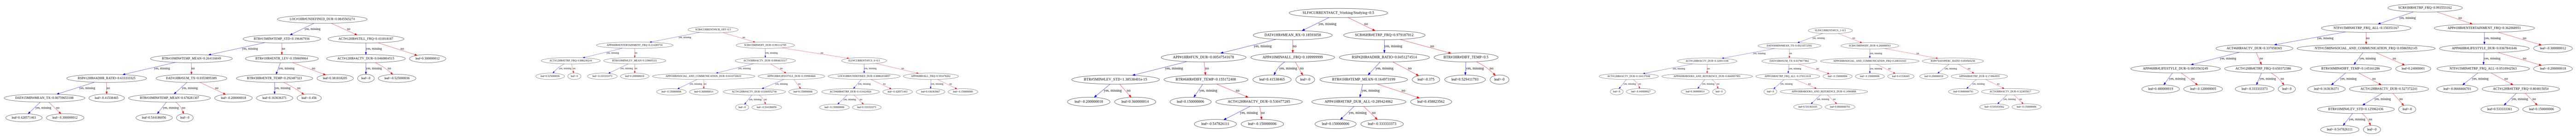

In [26]:
## XGBoost
import matplotlib.pyplot as plt
import xgboost as xgb

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(100, 25))

for model, ax in zip(XGB_MODELS, axes):
  xgb.plot_tree(model, ax=ax)

print("XGBoost Tree")
fig.show()

LIghtGBM Tree


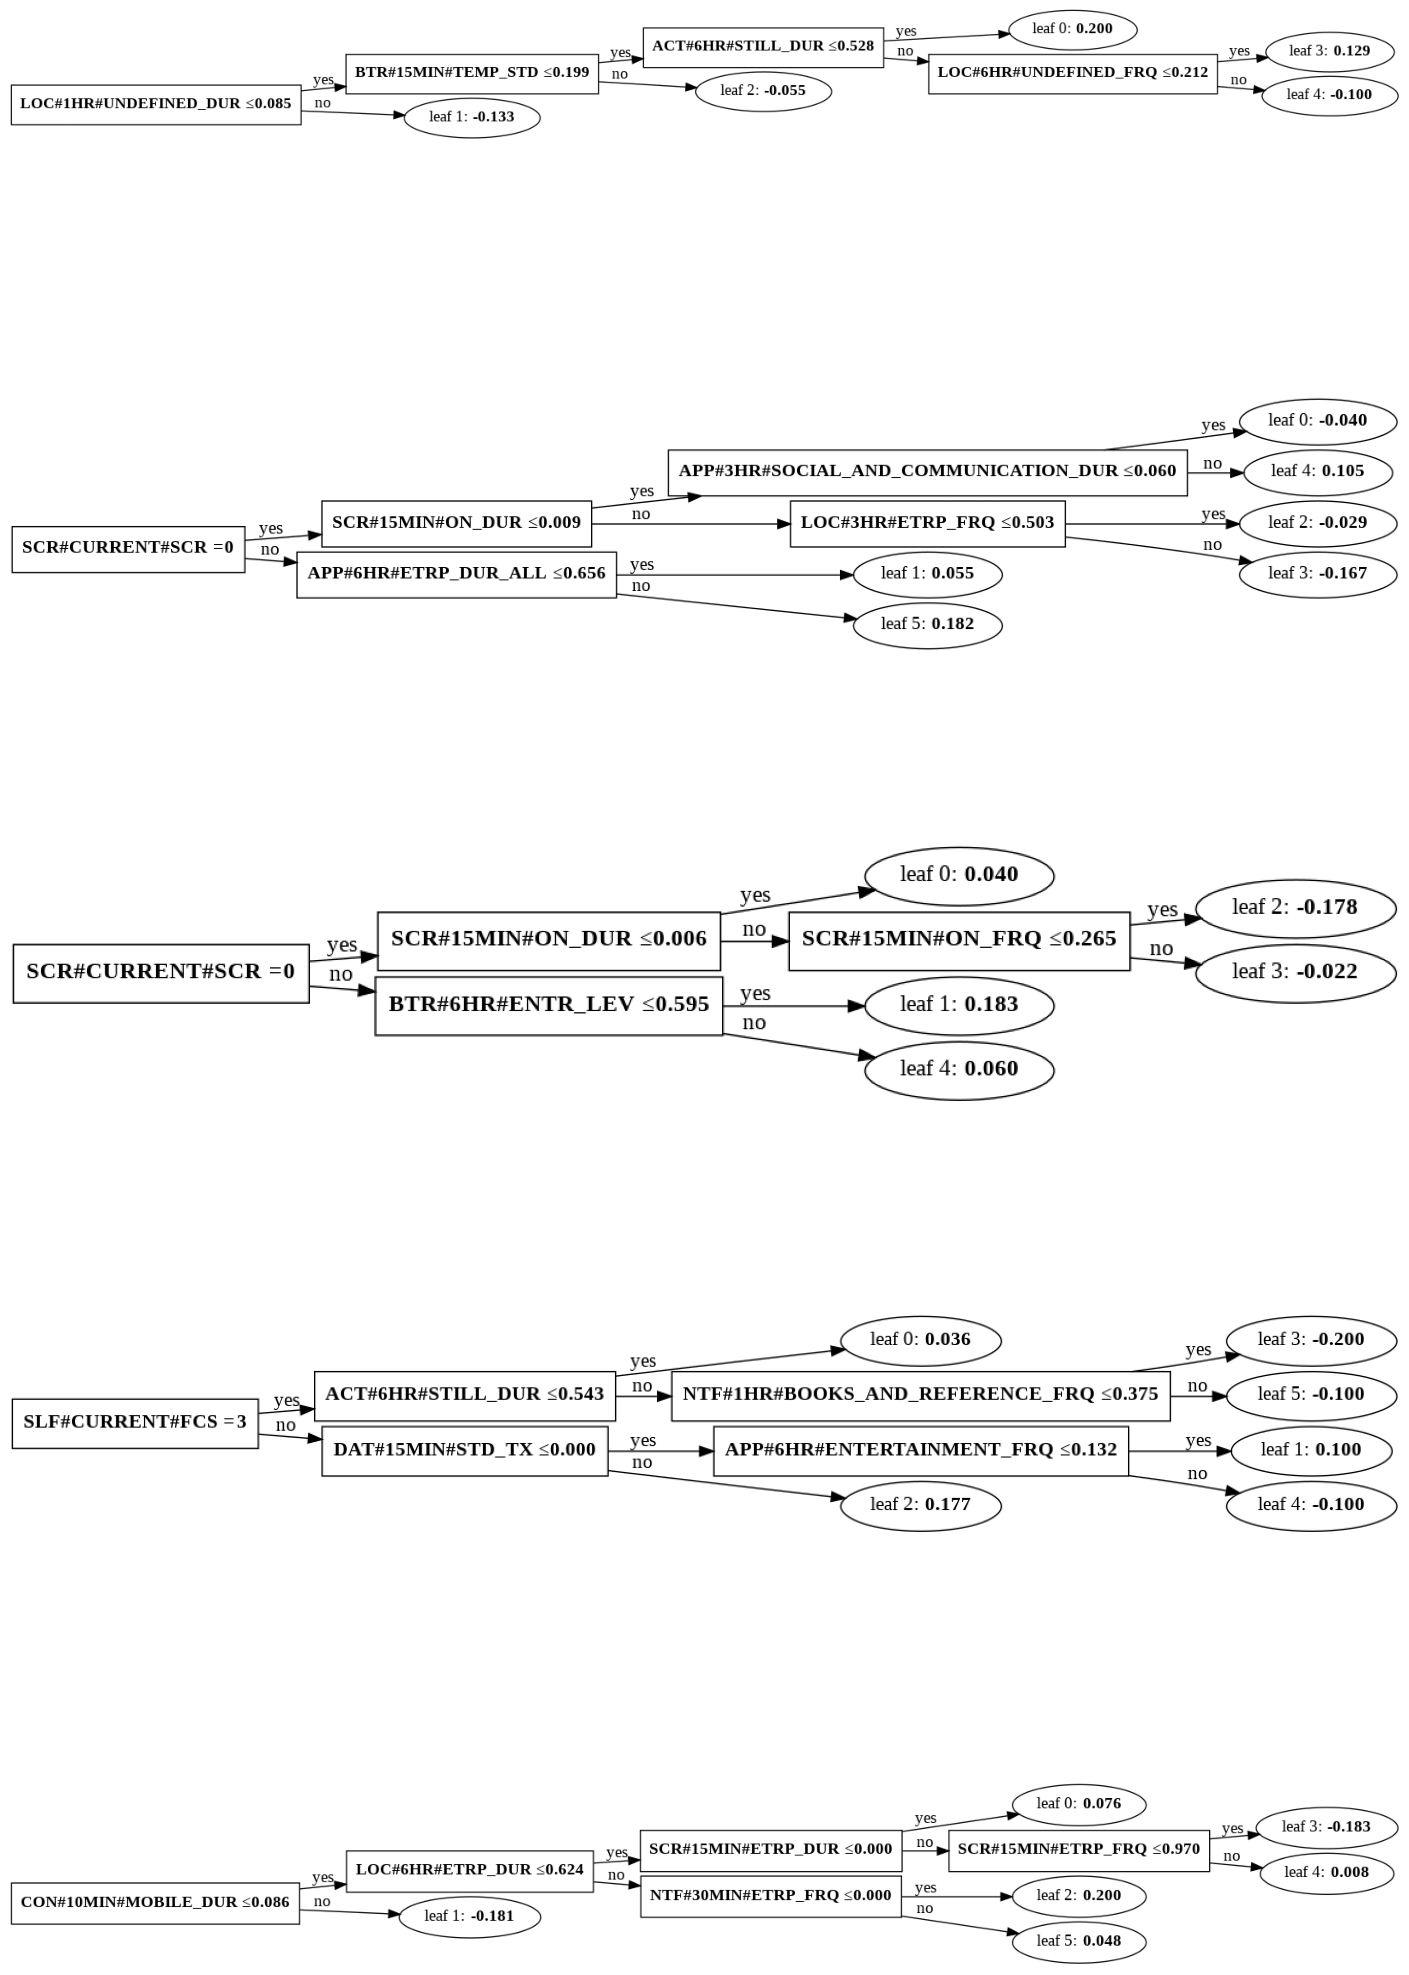

In [27]:
## LIghtGBM
import lightgbm as gbm

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(25, 40))

for model, ax in zip(GBM_MODELS, axes):
  gbm.plot_tree(model, ax=ax)

print("LIghtGBM Tree")
fig.show()

### Feature Contribution to Prediction

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


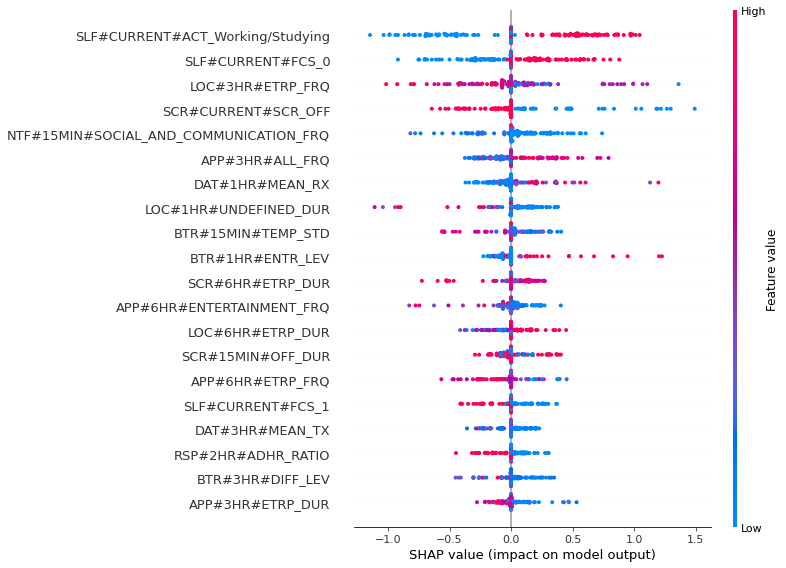

In [28]:
## XGBoost
import shap
import pandas as pd
import numpy as np

SHAP_VALUES = []
TEST_FEATURES = []

for (X_train, y_train, X_test, y_test), model in zip(K_FOLDS_OHE, XGB_MODELS):
  # shap.TreeExplainer() is used to explain tree-based ensemble models.
  explainer = shap.TreeExplainer(model)

  # TreeExplainer.shap_values indicate how features of each sample contribute to predicted output.
  shap_value = explainer.shap_values(X_test, tree_limit=model.best_ntree_limit)

  SHAP_VALUES.append(shap_value)
  TEST_FEATURES.append(X_test)

# Merging all shap values and train data.
SHAP_VALUES = np.vstack(SHAP_VALUES)
TEST_FEATURES = pd.concat(TEST_FEATURES, axis=0)

shap.summary_plot(SHAP_VALUES, TEST_FEATURES)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


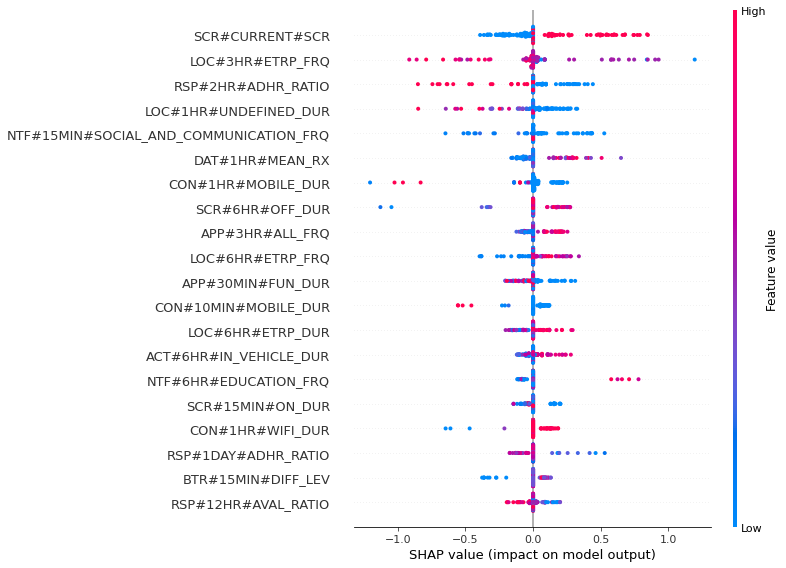

In [29]:
## LightGBM
import shap
import pandas as pd
import numpy as np

SHAP_VALUES = []
TEST_FEATURES = []

for (X_train, y_train, X_test, y_test), model in zip(K_FOLDS_ODE, GBM_MODELS):
  explainer = shap.TreeExplainer(model)
  
  # For LightGBM, TreeExplainer.shap_values() returns a list of shape values, 
  # where each element in a list is shap_values of each class.
  # In our case, the first element is shap_values for class label = 0, 
  # and the second one is shap_values for class label = 1.
  # We need to use only the second one.
  _, shap_value = explainer.shap_values(X_test, tree_limit=model.best_iteration)
  SHAP_VALUES.append(shap_value)
  TEST_FEATURES.append(X_test)

SHAP_VALUES = np.vstack(SHAP_VALUES)
TEST_FEATURES = pd.concat(TEST_FEATURES, axis=0)

shap.summary_plot(SHAP_VALUES, TEST_FEATURES)